## 1. Preprocessing

In [9]:
from imp import reload
from sqlalchemy import create_engine
from src import config, data_utils, preprocessing
import pandas as pd
import seaborn as sns

### Getting the data

In [10]:
app_train, app_test = data_utils.get_datasets()
app_train.columns

columns Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'duration_in_minutes', 'pickup_year', 'pickup_day',
       'pickup_day_of_week', 'pickup_hour', 'pickup_minute', 'trips_per_hour',
       'average_speed_per_hour'],
      dtype='object')


Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'duration_in_minutes', 'pickup_year', 'pickup_day',
       'pickup_day_of_week', 'pickup_hour', 'pickup_minute', 'trips_per_hour',
       'average_speed_per_hour'],
      dtype='object')

In [22]:
a2 = app_train.drop_duplicates(subset='pickup_hour')
a2[['pickup_hour', 'trips_per_hour', 'average_speed_per_hour']].head()

,pickup_hour,trips_per_hour,average_speed_per_hour
0,0,101898,25.577794
5,23,143681,24.172844
42,9,152979,38.743979
170,1,65741,20.237271
2109,17,237924,20.441649


In [5]:
app_train.dtypes

VendorID                   object
passenger_count           float64
trip_distance             float64
RatecodeID                 object
store_and_fwd_flag         object
PULocationID               object
DOLocationID               object
payment_type               object
fare_amount               float64
extra                     float64
mta_tax                   float64
tip_amount                float64
tolls_amount              float64
improvement_surcharge     float64
total_amount              float64
congestion_surcharge      float64
airport_fee               float64
duration_in_minutes       float64
pickup_year               float64
pickup_day                  int32
pickup_day_of_week          int32
pickup_minute               int32
trips_per_hour              int64
average_speed_per_hour    float64
dtype: object

In [12]:
#app_train = app_train.sample(n=100000, random_state=56)
#app_test = app_test.sample(n=100000, random_state=56)


In [28]:
app_train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,total_amount,congestion_surcharge,airport_fee,duration_in_minutes,pickup_year,pickup_day,pickup_day_of_week,pickup_minute,trips_per_hour,average_speed_per_hour
count,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,...,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,3347127.0,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06,3.347127e+06
mean,1.696817e+00,1.393924e+00,3.438702e+00,1.057152e+00,1.638338e+02,1.627951e+02,1.214789e+00,1.422356e+01,1.085179e+00,4.983113e-01,...,2.101272e+01,2.343885e+00,9.608726e-02,1.591808e+01,2022.0,1.576454e+01,2.907641e+00,2.951354e+01,1.867043e+05,2.625654e+01
std,4.596337e-01,9.574029e-01,4.200654e+00,3.055534e-01,6.461555e+01,6.934054e+01,4.273888e-01,1.155289e+01,1.268541e+00,2.910224e-02,...,1.499987e+01,6.049091e-01,3.329810e-01,1.279937e+01,0.0,8.698652e+00,1.997744e+00,1.732313e+01,5.225847e+04,1.753692e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,...,3.100000e-01,0.000000e+00,0.000000e+00,1.666667e-02,2022.0,1.000000e+00,0.000000e+00,0.000000e+00,1.973800e+04,1.308690e+01
25%,1.000000e+00,1.000000e+00,1.130000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,7.000000e+00,0.000000e+00,5.000000e-01,...,1.230000e+01,2.500000e+00,0.000000e+00,7.583333e+00,2022.0,8.000000e+00,1.000000e+00,1.400000e+01,1.703370e+05,1.679389e+01
50%,2.000000e+00,1.000000e+00,1.900000e+00,1.000000e+00,1.610000e+02,1.620000e+02,1.000000e+00,1.000000e+01,5.000000e-01,5.000000e-01,...,1.596000e+01,2.500000e+00,0.000000e+00,1.241667e+01,2022.0,1.600000e+01,3.000000e+00,3.000000e+01,2.019670e+05,2.213442e+01
75%,2.000000e+00,1.000000e+00,3.500000e+00,1.000000e+00,2.330000e+02,2.340000e+02,1.000000e+00,1.600000e+01,2.500000e+00,5.000000e-01,...,2.256000e+01,2.500000e+00,0.000000e+00,1.995000e+01,2022.0,2.300000e+01,5.000000e+00,4.500000e+01,2.218730e+05,2.452387e+01
max,2.000000e+00,9.000000e+00,3.531000e+01,6.000000e+00,2.630000e+02,2.650000e+02,4.000000e+00,5.963000e+01,8.300000e+00,3.300000e+00,...,8.455500e+02,2.750000e+00,1.250000e+00,1.728167e+02,2022.0,3.100000e+01,6.000000e+00,5.900000e+01,2.533140e+05,8.652700e+01


In [3]:
columns_to_convert = ['VendorID', 'RatecodeID','PULocationID', 'DOLocationID', 'payment_type']
app_train[columns_to_convert] = app_train[columns_to_convert].astype('object')
app_test[columns_to_convert] = app_test[columns_to_convert].astype('object')

In [30]:
object_columns = app_train.select_dtypes(include='object').columns

for column in object_columns:
    print(f"\nColumn: {column}")
    print(app_train[column].value_counts())


Column: VendorID
VendorID
2    2332335
1    1014792
Name: count, dtype: int64

Column: RatecodeID
RatecodeID
1.0    3190876
2.0     142502
5.0       9647
3.0       2158
4.0       1916
6.0         28
Name: count, dtype: int64

Column: store_and_fwd_flag
store_and_fwd_flag
N    3293276
Y      53851
Name: count, dtype: int64

Column: PULocationID
PULocationID
237.0    169421
132.0    161272
236.0    147877
161.0    134303
142.0    116180
          ...  
105.0         1
184.0         1
27.0          1
118.0         1
199.0         1
Name: count, Length: 250, dtype: int64

Column: DOLocationID
DOLocationID
236    150476
237    146019
161    125619
230    101403
170     98609
        ...  
2           4
176         3
105         2
187         2
5           1
Name: count, Length: 257, dtype: int64

Column: payment_type
payment_type
1    2647604
2     684160
3      11324
4       4039
Name: count, dtype: int64


In [31]:
app_train.dtypes

VendorID                   object
passenger_count           float64
trip_distance             float64
RatecodeID                 object
store_and_fwd_flag         object
PULocationID               object
DOLocationID               object
payment_type               object
fare_amount               float64
extra                     float64
mta_tax                   float64
tip_amount                float64
tolls_amount              float64
improvement_surcharge     float64
total_amount              float64
congestion_surcharge      float64
airport_fee               float64
duration_in_minutes       float64
pickup_year               float64
pickup_day                  int32
pickup_day_of_week          int32
pickup_minute               int32
trips_per_hour              int64
average_speed_per_hour    float64
dtype: object

In [8]:
app_train.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration_in_minutes,pickup_year,pickup_day,pickup_day_of_week,pickup_minute,trips_per_hour,average_speed_per_hour
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.399380,3.437972,14.221077,1.090144,0.498140,2.696913,0.491065,0.299985,21.008476,2.349075,0.094662,15.893140,2022.0,15.714980,2.900040,29.650200,186491.218020,26.273361
std,0.965808,4.207811,11.570736,1.269269,0.030439,2.921236,1.756975,0.002121,14.975590,0.595431,0.330709,12.772383,0.0,8.699194,1.996484,17.306159,52429.215939,17.547476
min,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,0.000000,0.000000,0.016667,2022.0,1.000000,0.000000,0.000000,19738.000000,13.086898
25%,1.000000,1.130000,7.000000,0.000000,0.500000,1.000000,0.000000,0.300000,12.300000,2.500000,0.000000,7.550000,2022.0,8.000000,1.000000,15.000000,170337.000000,16.793892
50%,1.000000,1.900000,10.000000,0.500000,0.500000,2.160000,0.000000,0.300000,15.950000,2.500000,0.000000,12.358333,2022.0,16.000000,3.000000,30.000000,196474.000000,22.134422
75%,1.000000,3.500000,16.000000,2.500000,0.500000,3.360000,0.000000,0.300000,22.560000,2.500000,0.000000,19.916667,2022.0,23.000000,5.000000,45.000000,221873.000000,24.523872
max,6.000000,35.180000,59.500000,8.250000,0.500000,90.970000,55.000000,0.300000,141.760000,2.500000,1.250000,163.266667,2022.0,31.000000,6.000000,59.000000,253314.000000,86.526997


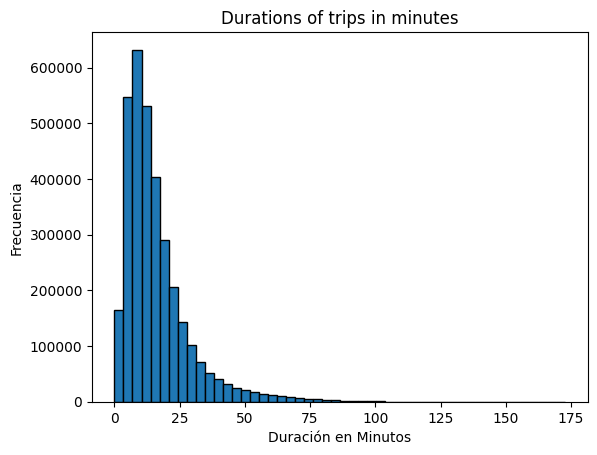

In [12]:
import matplotlib.pyplot as plt

# Suponiendo que duration_in_minutes es tu lista de duraciones

plt.hist(app_train.duration_in_minutes, bins=50, edgecolor='black')
plt.title('Durations of trips in minutes')
plt.xlabel('Duración en Minutos')
plt.ylabel('Frecuencia')
plt.show()

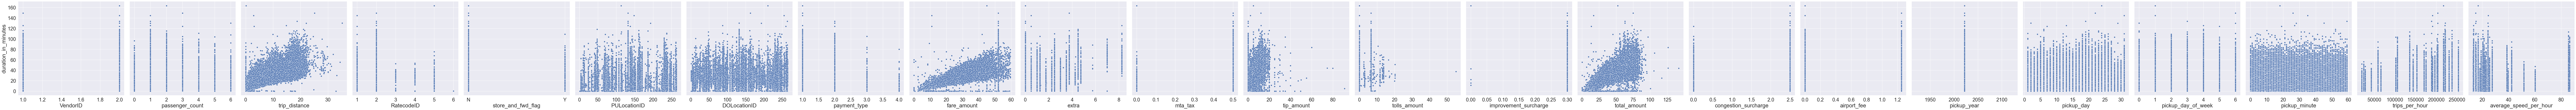

In [9]:
sns.set(font_scale = 2)
sns.pairplot(data = app_train,
             y_vars=['duration_in_minutes'],
             x_vars=['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'pickup_year', 'pickup_day',
       'pickup_day_of_week', 'pickup_minute', 'trips_per_hour',
       'average_speed_per_hour'],
             height=7)
             

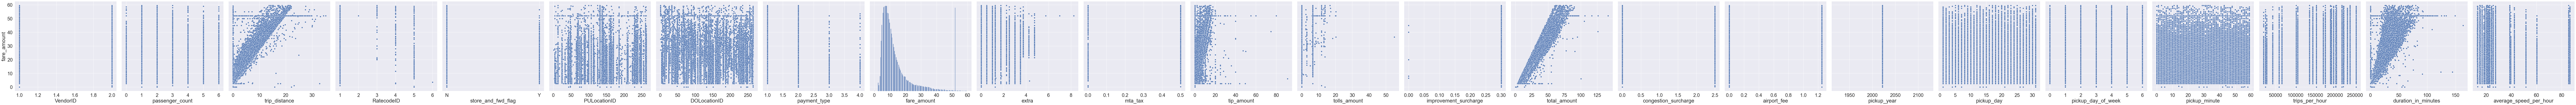

In [10]:
sns.set(font_scale = 2)
sns.pairplot(data = app_train,
             y_vars=['fare_amount'],
             x_vars=['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'pickup_year', 'pickup_day',
       'pickup_day_of_week', 'pickup_minute', 'trips_per_hour', 'duration_in_minutes',
       'average_speed_per_hour'],
             height=7)

In [11]:
app_train.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration_in_minutes,pickup_year,pickup_day,pickup_day_of_week,pickup_minute,trips_per_hour,average_speed_per_hour
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.399380,3.437972,14.221077,1.090144,0.498140,2.696913,0.491065,0.299985,21.008476,2.349075,0.094662,15.893140,2022.0,15.714980,2.900040,29.650200,186491.218020,26.273361
std,0.965808,4.207811,11.570736,1.269269,0.030439,2.921236,1.756975,0.002121,14.975590,0.595431,0.330709,12.772383,0.0,8.699194,1.996484,17.306159,52429.215939,17.547476
min,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,0.000000,0.000000,0.016667,2022.0,1.000000,0.000000,0.000000,19738.000000,13.086898
25%,1.000000,1.130000,7.000000,0.000000,0.500000,1.000000,0.000000,0.300000,12.300000,2.500000,0.000000,7.550000,2022.0,8.000000,1.000000,15.000000,170337.000000,16.793892
50%,1.000000,1.900000,10.000000,0.500000,0.500000,2.160000,0.000000,0.300000,15.950000,2.500000,0.000000,12.358333,2022.0,16.000000,3.000000,30.000000,196474.000000,22.134422
75%,1.000000,3.500000,16.000000,2.500000,0.500000,3.360000,0.000000,0.300000,22.560000,2.500000,0.000000,19.916667,2022.0,23.000000,5.000000,45.000000,221873.000000,24.523872
max,6.000000,35.180000,59.500000,8.250000,0.500000,90.970000,55.000000,0.300000,141.760000,2.500000,1.250000,163.266667,2022.0,31.000000,6.000000,59.000000,253314.000000,86.526997


In [4]:
numeric_df = app_train.select_dtypes(include=['int64', 'float64'])
numeric_df.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration_in_minutes,pickup_year,trips_per_hour,average_speed_per_hour
0,1.0,4.1,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0,18.700000,2022.0,101898,25.577794
1,1.0,2.3,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0,13.816667,2022.0,101898,25.577794
2,1.0,4.2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0,15.366667,2022.0,101898,25.577794
3,1.0,0.0,41.2,0.0,0.5,0.00,0.0,0.3,42.00,0.0,0.0,39.733333,2022.0,101898,25.577794
4,1.0,1.6,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0,9.383333,2022.0,101898,25.577794


<Axes: >

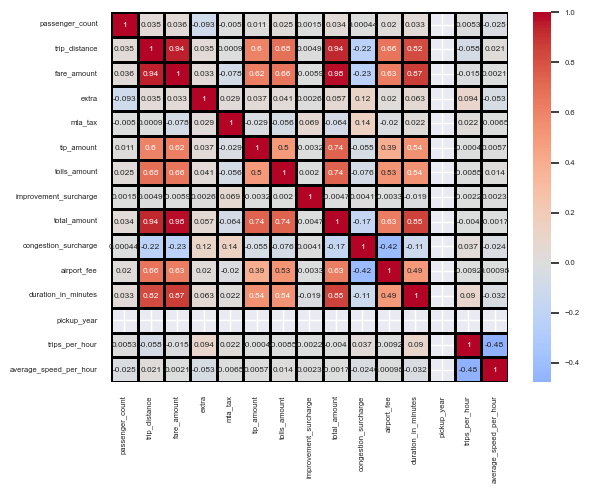

In [13]:
sns.set(font_scale = 0.5)
sns.heatmap(numeric_df.corr(),
            annot = True,
            fmt = '.2g',
            center= 0,
            cmap= 'coolwarm',
            linewidths= 1,
            linecolor='black')

<Axes: >

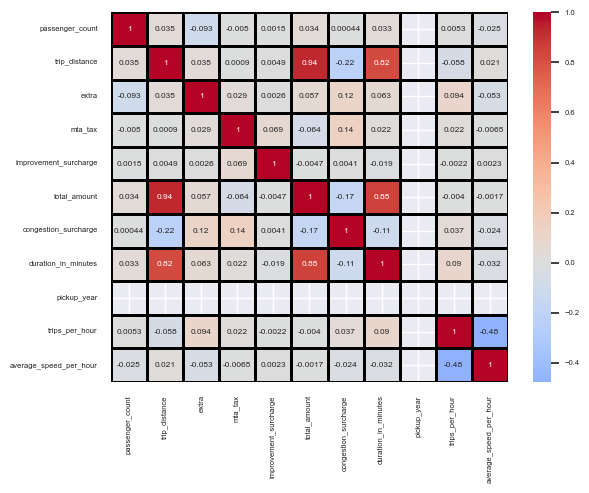

In [18]:
sns.set(font_scale = 0.5)
sns.heatmap(numeric_df.corr(),
            annot = True,
            fmt = '.2g',
            center= 0,
            cmap= 'coolwarm',
            linewidths= 1,
            linecolor='black')

In [4]:
columns_to_drop = ['fare_amount', 'tolls_amount','airport_fee','tip_amount', 'extra', 'mta_tax','improvement_surcharge','congestion_surcharge']
app_train = app_train.drop(columns=columns_to_drop)
app_test = app_test.drop(columns=columns_to_drop)

In [8]:
# Seleccionar columnas de tipo objeto
columnas_objeto = app_train.select_dtypes(include=['object'])
columnas_objeto.head()

,VendorID,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type
0,1,1.0,N,246.0,151,2
1,1,1.0,N,238.0,74,2
2,1,1.0,N,163.0,260,2
3,1,1.0,N,79.0,182,1
4,1,1.0,N,238.0,75,1


In [7]:
columns_to_drop = ['VendorID', 'RatecodeID','store_and_fwd_flag']
app_train = app_train.drop(columns=columns_to_drop)
app_test = app_test.drop(columns=columns_to_drop)

In [5]:
app_train.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,duration_in_minutes,pickup_year,pickup_day,pickup_day_of_week,pickup_hour,pickup_minute,trips_per_hour,average_speed_per_hour
0,1,1.0,4.1,1.0,N,246.0,151,2,20.80,18.700000,2022.0,1,6,0,0,101898,25.577794
1,1,1.0,2.3,1.0,N,238.0,74,2,14.80,13.816667,2022.0,1,6,0,27,101898,25.577794
2,1,1.0,4.2,1.0,N,163.0,260,2,19.30,15.366667,2022.0,1,6,0,59,101898,25.577794
3,1,1.0,0.0,1.0,N,79.0,182,1,42.00,39.733333,2022.0,1,6,0,48,101898,25.577794
4,1,1.0,1.6,1.0,N,238.0,75,1,13.55,9.383333,2022.0,1,6,0,28,101898,25.577794


In [9]:
app_train.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'total_amount', 'duration_in_minutes', 'pickup_year',
       'pickup_day', 'pickup_day_of_week', 'pickup_minute', 'trips_per_hour',
       'average_speed_per_hour'],
      dtype='object')

In [8]:
import json

# Asumiendo que 'app_train' es tu DataFrame
valores_unicos_trips_per_hour = app_train.groupby('pickup_hour')['trips_per_hour'].unique().apply(list).to_dict()
valores_unicos_average_speed_per_hour = app_train.groupby('pickup_hour')['average_speed_per_hour'].unique().apply(list).to_dict()

# Convierte los int64 a int estándar de Python y redondea a dos decimales
valores_unicos_trips_per_hour = {k: [round(float(i), 2) for i in v] for k, v in valores_unicos_trips_per_hour.items()}
valores_unicos_average_speed_per_hour = {k: [round(float(i), 2) for i in v] for k, v in valores_unicos_average_speed_per_hour.items()}

with open('valores_unicos_trips_per_hour.json', 'w') as f:
    json.dump(valores_unicos_trips_per_hour, f)
with open('valores_unicos_average_speed_per_hour.json', 'w') as f:
    json.dump(valores_unicos_average_speed_per_hour, f)

In [5]:
# Crear el motor de la base de datos
# Aquí estoy asumiendo que estás usando SQLite y que quieres guardar los datos en un archivo llamado `mydatabase.db`
#engine = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

# Guardar los DataFrames en la base de datos
#app_train.to_sql('app_train', engine, if_exists='replace', index=False)
#app_test.to_sql('app_test', engine, if_exists='replace', index=False)

In [32]:
reload (data_utils)

<module 'src.data_utils' from 'c:\\Anyone\\repos\\Finall_project\\assignment\\taxi-price-predictor3\\final_project_Any\\src\\data_utils.py'>

## Split targets from dataset

In [42]:
(
 X_train,
 y_train_total_amount,
 y_train_duration_in_minutes,
 X_test,
 y_test_total_amount,
 y_test_duration_in_minutes
) = data_utils.get_feature_target(app_train, app_test)

## Stract validation dataset

In [43]:
(
X_train,
X_val,
y_train_total_amount,
y_val_total_amount,
y_train_duration_in_minutes,
y_val_duration_in_minutes
) = data_utils.get_train_val_sets(X_train, y_train_total_amount, y_train_duration_in_minutes)

In [44]:
print(X_train.shape, X_val.shape, X_test.shape)

(2677701, 11) (669426, 11) (3280445, 11)


## Clear and encode datasets

In [6]:
reload(preprocessing)                

<module 'src.preprocessing' from 'c:\\Anyone\\repos\\Finall_project\\assignment\\taxi-price-predictor\\src\\preprocessing.py'>

In [45]:
null_values = X_test.isnull().sum()
print(null_values)

passenger_count           0
trip_distance             0
PULocationID              0
DOLocationID              0
payment_type              0
pickup_year               0
pickup_day                0
pickup_day_of_week        0
pickup_minute             0
trips_per_hour            0
average_speed_per_hour    0
dtype: int64


In [13]:
reload(preprocessing)

<module 'src.preprocessing' from 'c:\\Anyone\\repos\\Finall_project\\assignment\\taxi-price-predictor3\\final_project_Any\\src\\preprocessing.py'>

In [46]:
X_train, X_val, X_test = preprocessing.preprocess_data(X_train, X_val, X_test)

Input train data shape:  (2677701, 11)
Input val data shape:  (669426, 11)
Input test data shape:  (3280445, 11) 



c:\Anyone\repos\Anyone-AI-Sprint-3\env\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Anyone\repos\Anyone-AI-Sprint-3\env\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [81]:
import statsmodels.api as sm

# Asumiendo que 'scaled_train_df' es tu DataFrame de características y 'y_train' es tu variable objetivo
X = sm.add_constant(X_train.toarray())  # Convertir a matriz densa y añadir una constante (intercepto) al modelo
model = sm.OLS(y_train_duration_in_minutes, X)
results = model.fit()

print(results.summary())

ValueError: endog and exog matrices are different sizes

In [87]:
X_train.head()

AttributeError: head not found

In [86]:
X_train2 = X_train.sample(n=10000, random_state=1)

AttributeError: sample not found

In [82]:
import pandas as pd



# Ajustar el modelo
X = sm.add_constant(X_train2.toarray())   # Añadir una constante (intercepto) al modelo
model = sm.OLS(y_train_duration_in_minutes, X)
results = model.fit()

# Crear un DataFrame a partir de los resultados del modelo
summary = pd.DataFrame(results.summary().tables[1].data)

# Configurar las columnas y el índice
summary.columns = summary.iloc[0]
summary = summary.drop(0)
summary = summary.set_index(summary.columns[0])

# Convertir los valores p a float
summary['P>|t|'] = summary['P>|t|'].astype(float)

# Filtrar las variables con un valor p menor o igual a 0.05
significant_vars = summary[summary['P>|t|'] <= 0.05].index

print(significant_vars)
print(results.summary())

c:\Anyone\repos\Anyone-AI-Sprint-3\env\lib\site-packages\statsmodels\tools\tools.py:271: RuntimeWarning: overflow encountered in scalar divide
  s[i] = 1./s[i]


MemoryError: Unable to allocate 10.2 GiB for an array with shape (517, 2645788) and data type float64

In [69]:
# Create a XGBoost matrices
import xgboost as xgb

x_train2 = xgb.DMatrix(X_train, label=y_train_duration_in_minutes)
X_val2 = xgb.DMatrix(X_val, label=y_val_duration_in_minutes)

In [70]:
parameters = {'learning_rate': 0.3,
              'max_depth': 6,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 0,
              'random_state': 42,
              'eval_metric': 'rmse',
              'objective': 'reg:squarederror'}

In [10]:
import subprocess

command = f"{sys.executable} -m pip freeze > requirements2.txt"
subprocess.run(command, shell=True)

NameError: name 'sys' is not defined

In [71]:
model = xgb.train(parameters, 
                dtrain = x_train2, 
                num_boost_round=15, 
                evals=[(X_val2, 'duration_in_minutes')], 
                verbose_eval=10)

[0]	duration_in_minutes-rmse:9.26812
[10]	duration_in_minutes-rmse:5.02186
[14]	duration_in_minutes-rmse:4.93715


In [72]:
predictions = model.predict(X_val2)
predictions[:5]

array([17.491133, 33.32363 ,  7.66131 ,  9.810026, 18.52591 ],
      dtype=float32)

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
print(round(mean_absolute_error(y_val_duration_in_minutes, predictions), 2))
print(round(mean_squared_error(y_val_duration_in_minutes, predictions), 2))
print(round(np.sqrt(mean_squared_error(y_val_duration_in_minutes, predictions)), 2))
print(round(r2_score(y_val_duration_in_minutes, predictions), 2))

3.34
24.38
4.94
0.83


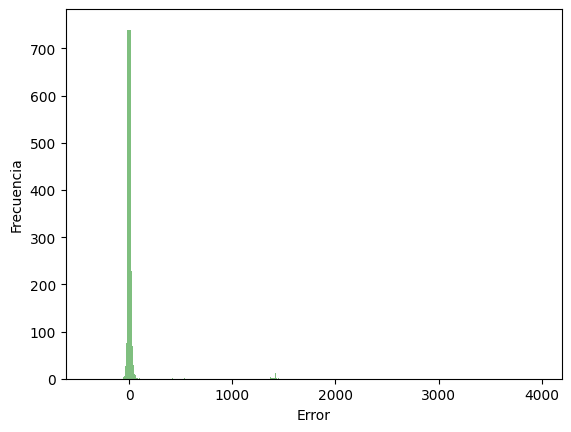

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que y_val2 son los valores reales
# Realizar las predicciones
predictions = model.predict(X_val2)

# Calcular los errores
errors = y_val_duration_in_minutes - predictions

# Calcular las frecuencias y los bordes de los bins
frequencies, bin_edges = np.histogram(errors, bins='auto')

# Filtrar los bins cuya frecuencia sea menor a 2000
filtered_bin_edges = bin_edges[:-1][frequencies < 750]
filtered_frequencies = frequencies[frequencies < 750]

# Crear una figura y un conjunto de subtramas
fig, ax = plt.subplots()

# Crear un histograma con los errores filtrados
# Usar np.diff(filtered_bin_edges) para obtener el ancho de los bins filtrados
# Agregar un último valor para que coincida con la longitud de filtered_bin_edges y filtered_frequencies
widths = np.append(np.diff(filtered_bin_edges), np.diff(filtered_bin_edges)[-1])

ax.bar(filtered_bin_edges, filtered_frequencies, width=widths, align="edge", alpha=0.5, color='g')

# Establecer las etiquetas de los ejes
ax.set_xlabel('Error')
ax.set_ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

## Models

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
import xgboost as xgb
import pickle


# LightGBM Regressor (using validation set)
lgbm = LGBMRegressor(random_state=42)

# Train on training features and duration target
lgbm.fit(X_train, y_train_total_amount)

# Make predictions on validation set features
y_pred_lgbm = lgbm.predict(X_val)

# Evaluate on validation set - duration
r2_lgbm_val = r2_score(y_val_total_amount, y_pred_lgbm)
mse_lgbm_val = mean_squared_error(y_val_total_amount, y_pred_lgbm)

# Print validation set results (f-string for readability)
print(f"LightGBM Regressor (Validation) - R2: {r2_lgbm_val:.4f}, MSE: {mse_lgbm_val:.4f}")

# XGBoost Regressor (using validation set)
xgbr = xgb.XGBRegressor(random_state=42)

# Train on training features and duration target
xgbr.fit(X_train, y_train_duration_in_minutes)

# Make predictions on validation set features
y_pred_xgbr = xgbr.predict(X_val)

# Evaluate on validation set - duration
r2_xgbr_val = r2_score(y_val_duration_in_minutes, y_pred_xgbr)
mse_xgbr_val = mean_squared_error(y_val_duration_in_minutes, y_pred_xgbr)

with open('time_model1.pkl', 'wb') as file:
    pickle.dump(xgbr, file)

with open('Rate.pkl', 'wb') as file:
    pickle.dump(lgbm, file)


# Print validation set results (f-string for readability)
print(f"XGBoost Regressor (Validation) - R2: {r2_xgbr_val:.4f}, MSE: {mse_xgbr_val:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 2677701, number of used features: 460
[LightGBM] [Info] Start training from score 21.004335
LightGBM Regressor (Validation) - R2: 0.9340, MSE: 14.8894
XGBoost Regressor (Validation) - R2: 0.8558, MSE: 23.7678


### Linear Regression

[[0.2        0.90458015 0.94656489 ... 1.         0.95652174 0.10169492]
 [0.         1.         0.87022901 ... 0.66666667 0.69565217 0.50847458]
 [0.2        0.61832061 0.33969466 ... 1.         0.91304348 0.33898305]
 ...
 [0.         0.29770992 0.59923664 ... 0.66666667 0.56521739 0.88135593]
 [0.         0.5        0.8740458  ... 0.33333333 0.43478261 0.96610169]
 [0.         0.32824427 0.79389313 ... 0.66666667 0.52173913 0.96610169]]


#### Total amount prediction

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from src.save_model import save_total_trip_model,save_duration_trip_model
import math

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train_total_amount)

save_total_trip_model(model)
# Predict using the model

y_pred_train = model.predict(X_train)
print('MAE:', mean_absolute_error(y_train_total_amount, y_pred_train))
print('MSE:', mean_squared_error(y_train_total_amount, y_pred_train))
print('RMSE:', math.sqrt(mean_squared_error(y_train_total_amount, y_pred_train)))
print('R2:', r2_score(y_train_total_amount, y_pred_train))
print('_________________________:')

y_pred_val = model.predict(X_val)
print('MAE:', mean_absolute_error(y_val_total_amount, y_pred_val))
print('MSE:', mean_squared_error(y_val_total_amount, y_pred_val))
print('RMSE:', math.sqrt(mean_squared_error(y_val_total_amount, y_pred_val)))
print('R2:', r2_score(y_val_total_amount, y_pred_val))

MAE: 2.8086210629519184
MSE: 27.141590048488688
RMSE: 5.209759116167339
R2: 0.8811266542718111
_________________________:
MAE: 2.813666590342059
MSE: 28.23428701683792
RMSE: 5.313594547652081
R2: 0.8764907766884821


#### Trip duration prediction

In [16]:
# Create a linear regression model
model_duration = LinearRegression()

print(X_train.shape)
print(y_train_duration_in_minutes.shape)
# Fit the model
model_duration.fit(X_train, y_train_duration_in_minutes)

save_duration_trip_model(model_duration)
# Predict using the model

y_pred_train = model_duration.predict(X_train)
print('MAE:', mean_absolute_error(y_train_duration_in_minutes, y_pred_train))
print('MSE:', mean_squared_error(y_train_duration_in_minutes, y_pred_train))
print('RMSE:', math.sqrt(mean_squared_error(y_train_duration_in_minutes, y_pred_train)))
print('R2:', r2_score(y_train_duration_in_minutes, y_pred_train))
print('_________________________:')

y_pred_val = model_duration.predict(X_val)
print('MAE:', mean_absolute_error(y_val_duration_in_minutes, y_pred_val))
print('MSE:', mean_squared_error(y_val_duration_in_minutes, y_pred_val))
print('RMSE:', math.sqrt(mean_squared_error(y_val_duration_in_minutes, y_pred_val)))
print('R2:', r2_score(y_val_duration_in_minutes, y_pred_val))

(2719177, 14)
(2719177,)
MAE: 7.130545491759533
MSE: 2585.3035500505002
RMSE: 50.845880364592965
R2: 0.04638534918213155
_________________________:
MAE: 7.180097380761046
MSE: 2630.3419937913004
RMSE: 51.28685985504767
R2: 0.04673809475902069


### DecisionTreeRegressor

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

In [18]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train_total_amount)

# Evaluate the model
y_pred_train_DTR = tree.predict(X_train)



print('MAE:', mean_absolute_error(y_train_total_amount, y_pred_train_DTR))
print('MSE:', mean_squared_error(y_train_total_amount, y_pred_train_DTR))
print('RMSE:', math.sqrt(mean_squared_error(y_train_total_amount, y_pred_train_DTR)))
print('R2:', r2_score(y_train_total_amount, y_pred_train_DTR))

y_pred_val_DTR = tree.predict(X_val)

print('val:')

print('MAE:', mean_absolute_error(y_val_total_amount, y_pred_val_DTR))
print('MSE:', mean_squared_error(y_val_total_amount, y_pred_val_DTR))
print('RMSE:', math.sqrt(mean_squared_error(y_val_total_amount, y_pred_val_DTR)))
print('R2:', r2_score(y_val_total_amount, y_pred_val_DTR))

MAE: 2.250430428004386
MSE: 17.148608060381058
RMSE: 4.1410877870894085
R2: 0.9248934048787465
val:
MAE: 2.2630443000410163
MSE: 18.44348940892286
RMSE: 4.294588386437385
R2: 0.9193200433681294


### XGBRegressor

In [143]:
import xgboost as xgb
print('__version__',xgb.__version__)
from sklearn.datasets import make_regression
#XGBRegressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=1, random_state=42,
                               n_estimators=500, max_depth=5, learning_rate=00.1, 
                               subsample=0.8, colsample_bytree=0.8)

# Fit the model
model_xgb.fit(X_train, y_train_total_amount)

y_pred_train_xgb = model.predict(X_train)

print('MAE:', mean_absolute_error(y_train_total_amount, y_pred_train_xgb))
print("MSE:", mean_squared_error(y_train_total_amount, y_pred_train_xgb))
print('RMSE:', math.sqrt(mean_squared_error(y_train_total_amount, y_pred_train_xgb)))
r2 = r2_score(y_train_total_amount, y_pred_train_xgb)
print(f"R2: {r2_score(y_train_total_amount, y_pred_train_xgb):.2f}")

# Predicting the Test set results
y_pred_val_xgb = model.predict(X_val)

print("Val:")
print('MAE:', mean_absolute_error(y_val_total_amount, y_pred_val_xgb))
print("MSE:", mean_squared_error(y_val_total_amount, y_pred_val_xgb))
print('RMSE:', math.sqrt(mean_squared_error(y_val_total_amount, y_pred_val_xgb)))
print(f"R2: {r2_score(y_val_total_amount, y_pred_val_xgb):.2f}")

__version__ 2.0.3
MAE: 8.499936202490034
MSE: 227.1152783615407
RMSE: 15.070344334537971
R2: 0.34
Val:
MAE: 8.459752577545961
MSE: 204.6382722531288
RMSE: 14.305183405085334
R2: 0.36


#### Random Forest Regressor

In [150]:
rf_reg = RandomForestRegressor(n_estimators=6, max_depth=5, random_state=42, n_jobs=1)
rf_reg.fit(X_train, y_train_total_amount)

# Evaluate the model
y_pred_train_RFR = rf_reg.predict(X_train)

print('MAE:', mean_absolute_error(y_train_total_amount, y_pred_train_RFR))
print("MSE:", mean_squared_error(y_train_total_amount, y_pred_train_RFR))
print('RMSE:', math.sqrt(mean_squared_error(y_train_total_amount, y_pred_train_RFR)))
r2 = r2_score(y_train_total_amount, y_pred_train_RFR)
print(f"R2: {r2_score(y_train_total_amount, y_pred_train_RFR):.2f}")

# Predicting the Test set results
y_pred_val_RFR = model.predict(X_val)

print("Val:")
print('MAE:', mean_absolute_error(y_val_total_amount, y_pred_val_RFR))
print("MSE:", mean_squared_error(y_val_total_amount, y_pred_val_RFR))
print('RMSE:', math.sqrt(mean_squared_error(y_val_total_amount, y_pred_val_RFR)))
print(f"R2: {r2_score(y_val_total_amount, y_pred_val_RFR):.2f}")

MAE: 7.254991895333542
MSE: 172.27699229871806
RMSE: 13.125433032807644
R2: 0.50
Val:
MAE: 8.459752577545961
MSE: 204.6382722531288
RMSE: 14.305183405085334
R2: 0.36


## Advanced cross validation



In [153]:
from sklearn.model_selection import cross_val_score, KFold
X, y = X_train, y_train_total_amount
# Create a random forest regression model
model = RandomForestRegressor(n_estimators=10)

# Configure the cross-validation procedure
cv = KFold(n_splits=10, shuffle=True)

# Evaluate the model using the cross-validation procedure
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)

# The scores are negative, which is how scikit-learn shows them for MSE (want to maximize negative MSE)
mse_scores = -scores

# Mean and standard deviation of MSE across all folds
print("MSE:", mse_scores.mean(), "Std:", mse_scores.std())

MSE: 115.78741919896211 Std: 49.406062188298016


In [154]:
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
# Base models
model1 = RandomForestRegressor(random_state=42)
model2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=123)
model3 = RandomForestRegressor(n_estimators=100)

# Defining the meta model, using a regressor 
meta_model = RandomForestRegressor(random_state=42)

# Create Stacking model
stacking_model = StackingRegressor(
    estimators=[('rf1', model1), ('xgb', model2), ('rf2', model3)],
    final_estimator=meta_model,
    cv=5
)

# Training the model
stacking_model.fit(X_train, y_train_total_amount)

# Predictions
y_pred = stacking_model.predict(X_test)

# Evaluation metrics
# Calculate MSE
mse = mean_squared_error(y_test_total_amount, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")